In [2]:
import numpy as np
import os
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
tf.__version__

'2.18.0'

In [4]:
import tf_keras

mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
classifier_model = mobilenet_v2
IMAGE_SHAPE = (224, 224)

classifier = tf_keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=30

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "output",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7390 files belonging to 2 classes.


In [7]:
class_names = dataset.class_names
class_names

['cat', 'dog']

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
len(val_ds)*BATCH_SIZE

736

In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(224, 224),
    layers.Rescaling(1.0/255)
])

In [12]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [13]:
import tf_keras
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

# Özellik çıkarıcı katman
pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=True
)

# Sınıflandırıcı model
num_of_categories = 2  # Kedi ve köpek
model = tf_keras.Sequential([
    pretrained_model_without_top_layer,
    tf_keras.layers.Dense(num_of_categories, activation='softmax')  # Sınıflandırıcı katman
])

# Modeli derleme
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

# Modeli özetleyin
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2226434 (8.49 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


In [14]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=2,
)

Epoch 1/2



C:\Users\samet\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



184/184 [==============================] - 166s 829ms/step - loss: 0.2493 - accuracy: 0.9460 - val_loss: 0.1645 - val_accuracy: 0.9701
Epoch 2/2
184/184 [==============================] - 152s 814ms/step - loss: 0.1678 - accuracy: 0.9726 - val_loss: 0.2328 - val_accuracy: 0.9592


In [41]:
# Dataset'ten bir batch alalım
for images, labels in dataset.take(1):  # İlk batch'i alın
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    break

Images shape: (32, 224, 224, 3)
Labels shape: (32,)


In [42]:
# İlk batch'in ilk görüntüsünü al
single_image = images[0]  # İlk batch'in ilk görüntüsü
single_label = labels[0]  # Buna karşılık gelen etiket

# Görüntünün boyutunu kontrol edelim
print(f"Single image shape: {single_image.shape}")
print(f"Label: {single_label.numpy()}")

Single image shape: (224, 224, 3)
Label: 0


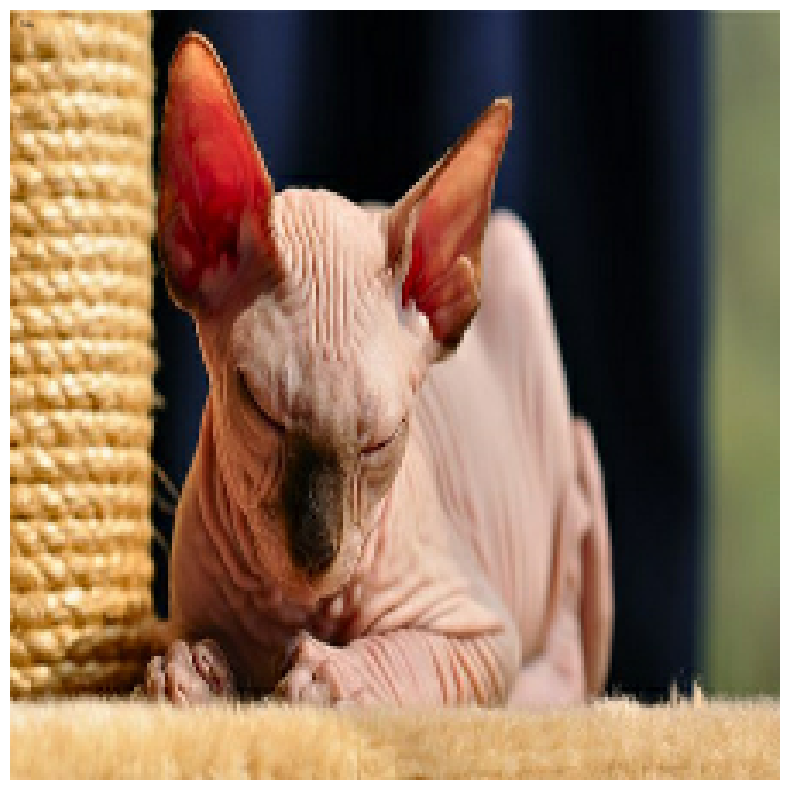

In [43]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
        plt.imshow(single_image.numpy().astype("uint8"))
        
        plt.axis("off")

In [44]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
normalized_image = single_image / 255.0
image_array = img_to_array(normalized_image)
image_array_with_batch = np.expand_dims(image_array, axis=0)


In [45]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_image(image_path):
    # Görüntüyü yükle ve yeniden boyutlandır
    image = load_img(image_path, target_size=(224, 224))
    image_array = img_to_array(image) / 255.0  # Normalizasyon
    return np.expand_dims(image_array, axis=0)  # Batch boyutunu ekle

# Kullanıcıdan gelen fotoğraf
user_image_path = "C:/Users/samet/OneDrive/Masaüstü/proje dökümanları/kedi.jpg"
user_image = preprocess_image(user_image_path)

# Sınıflandırmayı yap
class_labels = ["cat", "dog"]  # Sınıf isimleri
predictions = model.predict(image_array_with_batch)
probabilities = tf.nn.softmax(predictions).numpy()
print("Class Probabilities:", probabilities)

1/1 [==============================] - 0s 40ms/step
Class Probabilities: [[0.26899576 0.7310042 ]]
